In [1]:
import os
import pywt
import torch
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from quantus.metrics import Complexity
from scipy.fftpack import fft, fftfreq
from torch.utils.data import DataLoader, TensorDataset

from src.models.simple import SimpleCNN
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# set seed
set_seed(42)

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

# load the model
model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=5)

# load the model weights
model.load_state_dict(torch.load("./model/checkpoint/simpleCNN_5.pth", map_location=torch.device('mps')))
model.to(device)

Using device: mps


SimpleCNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 2, kernel_size=(5,), stride=(1,))
    (4): AdaptiveAvgPool1d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)

In [4]:
set_seed(42)

# Load and shape synthetic test data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test_3"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Shuffle indices once
indices = torch.randperm(len(x))

# Apply the shuffle
x_shuffled = x[indices]
y_shuffled = y[indices]

# create the dataset
dataset = TensorDataset(x_shuffled, y_shuffled)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128)


(10000, 1, 16)
(10000,)


In [5]:
attributions = {}
attributions['deletion'] = {}
attributions['insertion'] = {}
predictions = []
labels = []

# prediction
for batch in test_loader:
    # get data
    x, y = batch
    x = x.to(device)
    output = model(x)

    predictions.append(output)
    labels.append(y)

# concatenat the predictions and the labels through the first dim
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0)

In [6]:
correct = 0
for i in range(len(predictions)):
    if predictions[i].argmax() == labels[i]:
        correct += 1

print(f"Accuracy: {correct / len(predictions)}")

Accuracy: 1.0


In [7]:
# save it in the attributions dict
attributions['predictions'] = predictions
attributions['labels'] = labels

In [8]:
# evaluate wavelet
fs = 16
batch_size = 128
wavelet = 'db'
w_len = 1
normalized = True
level = pywt.dwt_max_level(fs, 'db1')
key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
print(key_)

wavelet_db1_4_128


In [9]:
# set the seed for reproducibility
set_seed(42)

# compute the attributions
method = 'wavelet'

args = SimpleNamespace(wavelet=wavelet, len_w=w_len, level=level, sample_freq=fs)
print(args.wavelet)
print(args.len_w)
print(args.level)
print(args.sample_freq)

attrs, masks = compute_attribution(method = method, model = model, test_loader= test_loader, args = args, device=device, normalize=normalized)

db
1
4
16
Batch 0 of 79
Sample 0 of 128
Epoch 0: Loss=1.7463, Target=1.2963, Reg=0.4500
Epoch 10: Loss=0.8630, Target=0.4676, Reg=0.3954
Epoch 20: Loss=0.6670, Target=0.3139, Reg=0.3530
Epoch 30: Loss=0.6178, Target=0.3133, Reg=0.3044
Epoch 40: Loss=0.5656, Target=0.3133, Reg=0.2523
Epoch 50: Loss=0.5114, Target=0.3133, Reg=0.1981
Epoch 60: Loss=0.4905, Target=0.3133, Reg=0.1772
Epoch 70: Loss=0.4703, Target=0.3133, Reg=0.1570
Epoch 80: Loss=0.4502, Target=0.3133, Reg=0.1369
Epoch 90: Loss=0.4306, Target=0.3133, Reg=0.1173
Epoch 100: Loss=0.4131, Target=0.3133, Reg=0.0997
Epoch 110: Loss=0.3960, Target=0.3133, Reg=0.0827
Epoch 120: Loss=0.3834, Target=0.3134, Reg=0.0700
Epoch 130: Loss=0.3703, Target=0.3134, Reg=0.0569
Epoch 140: Loss=0.3615, Target=0.3134, Reg=0.0481
Epoch 150: Loss=0.3559, Target=0.3134, Reg=0.0425
Epoch 160: Loss=0.3509, Target=0.3135, Reg=0.0374
Epoch 170: Loss=0.3458, Target=0.3135, Reg=0.0322
Epoch 180: Loss=0.3405, Target=0.3136, Reg=0.0269
Epoch 190: Loss=0.335

In [10]:
attributions[key_] = attrs
attributions[f'filtermasks_{key_}'] = masks

In [11]:
print(attributions.keys())
print(key_)
print(len(attributions[key_]))
print(len(attrs[0]))
print(len(masks))
print(len(test_loader))

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_db1_4_128', 'filtermasks_wavelet_db1_4_128'])
wavelet_db1_4_128
79
128
79
79


In [12]:
# # read data
# folder = 'public/simple/'
# path = f'{folder}{key_}_results_3.pkl'

# with open(path, 'rb') as f:
#     attributions = pickle.load(f)
# print(f"Attributions loaded from {path}")

In [13]:
# print the type of attributions[key_]
print(type(attributions[key_]))

<class 'list'>


In [14]:
print(type(attributions[key_]))
print(len(attributions[key_]))
print(len(attributions[key_][0]))
print(len(attributions[key_][0][0]))
print(len(attributions[key_][0][0][0]))
print(len(attributions[key_][0][0][0][0]))

<class 'list'>
79
128
1
16
5


In [15]:
key_2 = f'filtermasks_{key_}'
print(type(attributions[key_2]))
print(len(attributions[key_2]))
print(len(attributions[key_2][0]))
print(len(attributions[key_2][0][0]))
print(len(attributions[key_2][0][0][0]))

<class 'list'>
79
128
16
5


In [16]:
set_seed(42)

# compute accuracy scores
quantiles = np.arange(0, 1.05, 0.05)
for mode in ['deletion', 'insertion']:
    if not mode in attributions.keys():
        attributions[mode] = {}
    
    acc_scores = evaluate_attributions(model, test_loader, attributions[key_], quantiles=quantiles, mode=mode, device=device, domain='wavelet', wavelet='db1')
    attributions[mode][key_] = acc_scores

In [17]:
print(attributions.keys())

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_db1_4_128', 'filtermasks_wavelet_db1_4_128'])


In [18]:
set_seed(42)

# stores the accuracy, mean true class prob and cross-entropy loss throughout the quantiles
for k in attributions['insertion'].keys():
    print(k)
    print(len(attributions['insertion'][k]))
    print(len(attributions['insertion'][k][0]))
    for val in range(len(attributions['insertion'][k])):
        print(attributions['insertion'][k][val])

wavelet_db1_4_128
3
21
[0.5, 0.5384, 0.6204, 0.6392, 0.6408, 0.6411, 0.6577, 0.6531, 0.6986, 0.7846, 0.8449, 0.9159, 0.976, 0.9992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.500000010728836, 0.5672658667564392, 0.6003002359390259, 0.614988046836853, 0.6190895615577697, 0.6197944349288941, 0.6631989582061768, 0.6614452718734741, 0.7015713850021362, 0.7719636610031128, 0.8266846131324768, 0.897700119972229, 0.9602106567382812, 0.9975745768547059, 0.9999320463180542, 0.9999665745735169, 0.9999704113960266, 0.9999723442077637, 0.9999723510742188, 0.9999723518371582, 0.9999722976684571]
[53.30962425470352, 38.62125685811043, 36.07988420128822, 34.99407371878624, 34.7425203025341, 35.684465646743774, 35.20076858997345, 35.9937824010849, 31.445500135421753, 22.171111449599266, 15.91435343772173, 9.014583870768547, 3.4879857211053604, 0.12869507836876437, 0.002676489267287252, 0.0013109663559589535, 0.0011609591565502342, 0.0010853063995455159, 0.001085028427951329, 0.0010849604559552972, 0.001087

In [19]:
# stores the accuracy, mean true class prob and cross-entropy loss throughout the quantiles
for k in attributions['deletion'].keys():
    print(k)
    print(len(attributions['deletion'][k]))
    print(len(attributions['deletion'][k][0]))
    for val in range(len(attributions['deletion'][k])):
        print(attributions['deletion'][k][val])

wavelet_db1_4_128
3
21
[1.0, 1.0, 0.9945, 0.9692, 0.9671, 0.9629, 0.9622, 0.9616, 0.9588, 0.9489, 0.9146, 0.8386, 0.77, 0.6152, 0.5127, 0.5007, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.9999722976684571, 0.9918925469398499, 0.9888395974159241, 0.9665058246612549, 0.9661289100646973, 0.9644483384132385, 0.9453275398254395, 0.9385719842910767, 0.9124963101387024, 0.8923059074401856, 0.8548732213973999, 0.7947013357162476, 0.7418986832618714, 0.6111347555160522, 0.5314114808082581, 0.5058161903858185, 0.5013025263786316, 0.5000470788002014, 0.4999217009544373, 0.4999136950492859, 0.500000010728836]
[0.0010873157571040792, 0.33762976177968085, 0.5539752311306074, 2.8299574833363295, 2.439129550009966, 2.667135396040976, 3.553475374355912, 3.825387554243207, 5.089479744434357, 6.629150342196226, 9.3569969907403, 15.30869933962822, 21.485898047685623, 35.929225116968155, 44.811414420604706, 51.14937072992325, 52.511390686035156, 53.05432140827179, 53.070691645145416, 53.074910283088684, 53.30962425470352]

In [20]:
complexities = {}
grad_complexties = {}
comp = Complexity()

In [21]:
set_seed(42)
# for att in attributions:
#     if att == 'insertion':
#         print(attributions['insertion'].keys())
    
# for key in attributions['insertion'].keys():
key = 'wavelet_db1_4_128'
if not key in complexities.keys():
    print('first')
    complexities[key] = []
    grad_complexties[key] = []

scores = []
grad_scores = []

for i in range(len(attributions[key])):
    expl = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
    expl = expl.to(dtype=torch.float32).numpy()
    
    ex = np.maximum(attributions[key][i].numpy(), 0)
    if 'filterbank' in key:
        ex = np.transpose(ex, (0, 2, 1))

    # min max normalize
    ex_min = np.min(ex, axis = -1, keepdims=True)
    ex_max = np.max(ex, axis = -1, keepdims=True)
    ex = (ex - ex_min) / (ex_max - ex_min + 1e-10)
    # ex = (ex - np.min(ex, axis = -1, keepdims=True)) / (np.max(ex, axis = -1, keepdims=True) - np.min(ex, axis = -1, keepdims=True) + 1e-10)
    expl_grad = np.abs(np.diff(ex, axis = -1)).sum(axis=-1)
    expl_grad = np.reshape(expl_grad, (attributions[key][i].shape[0], -1))

    expl = np.maximum(expl, 0)
    # check if all expl values are zero
    if np.all(expl == 0):
        print("All zeros")
        # add a small epsilon to avoid division by zero
        expl = np.ones_like(expl) * 1e-10

    # to compute complexities it has to be a numpy float32 otherwise err
    complexity = comp.evaluate_batch(expl, expl)
    complexity = np.nan_to_num(complexity)
    expl_grad = np.nan_to_num(expl_grad)
    scores += complexity.tolist()
    grad_scores += list(expl_grad)

complexities[key].append(np.mean(scores))
grad_complexties[key].append(np.mean(grad_scores))

print(complexities)
print(grad_complexties)

first
{'wavelet_db1_4_128': [np.float64(1.9872846442768732)]}
{'wavelet_db1_4_128': [np.float32(0.52606297)]}


In [32]:
import pickle

# dump to file
folder = 'public/simple/'
path = f'{folder}{key_}_results_3_normalized.pkl'

with open(path, 'wb') as f:
    pickle.dump(attributions, f)
print(f"Saved to {path}")

Saved to public/simple/wavelet_db1_4_128_results_3_normalized.pkl


In [44]:
import pywt

def plot_scaleogram_wav_heatmap(signal, attribution, prediction:int, label:int, fs=1000, level=9, ):
    # print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(level)]   # bands
    freq_bands.append(0)                                        # lowest frequency
    # print(freq_bands)

    time = np.linspace(0, len(signal) / fs, len(signal))
    

    # # normalize attribution scores to [0,1]
    # attribution = np.abs(attribution)
    # attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attribution[:-1, 1:]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    # force colorbar to be from 0 to 1
    plt.clim(0, 1)
    plt.title(f'Attribution pred:{prediction} true:{label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

In [34]:
# get one batch
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()

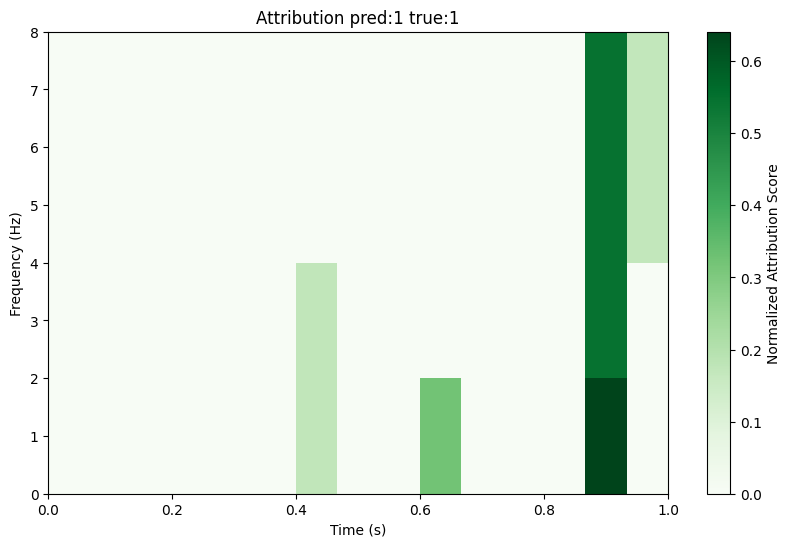

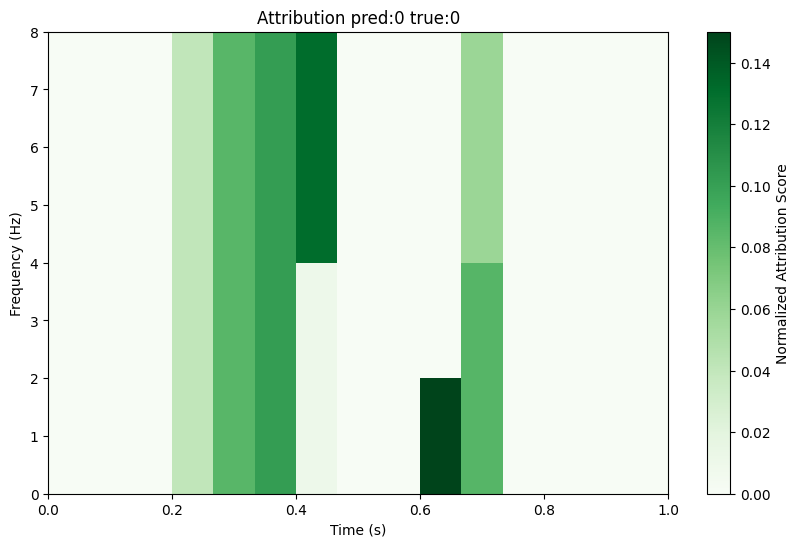

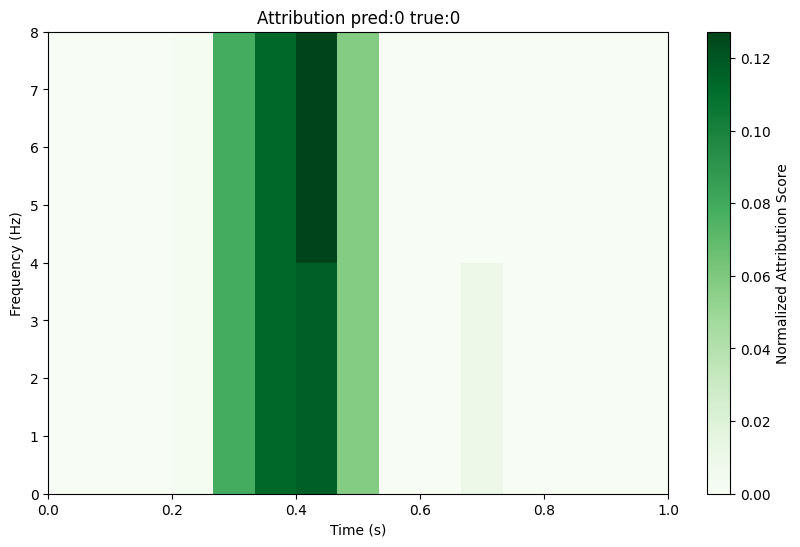

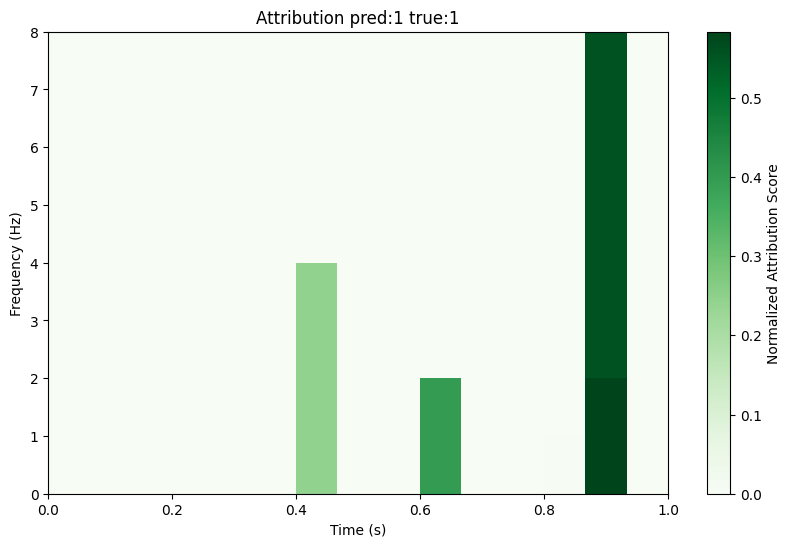

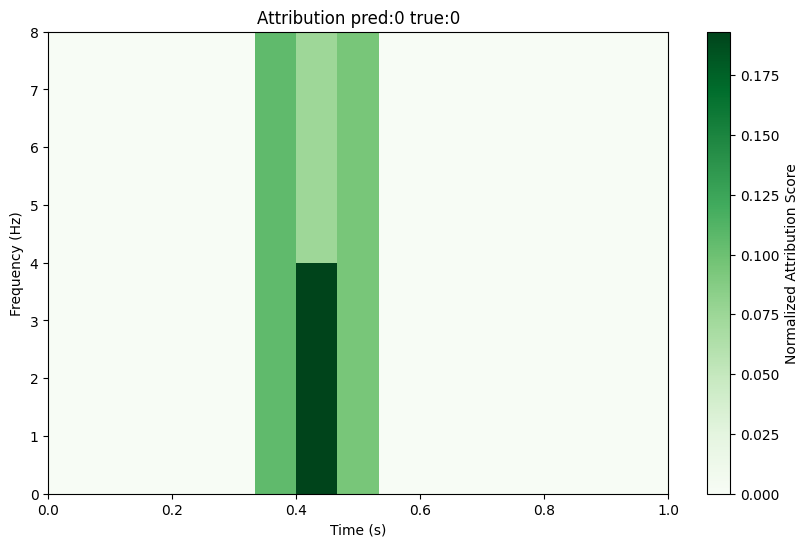

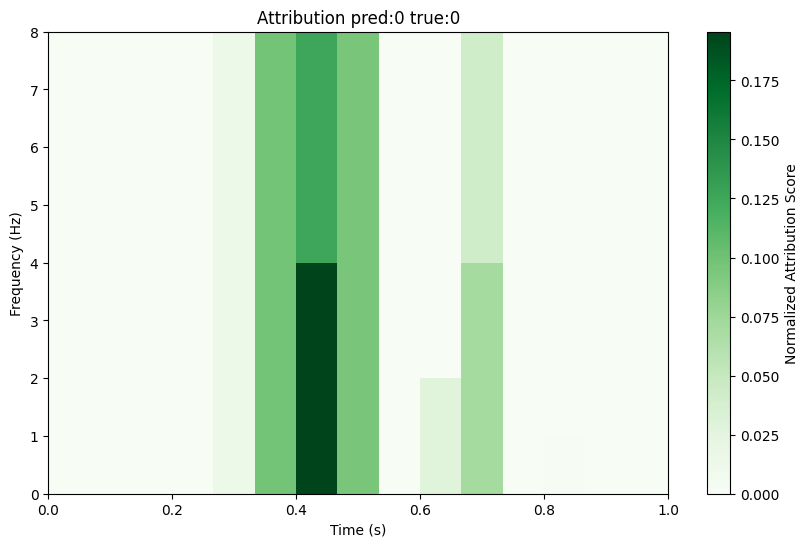

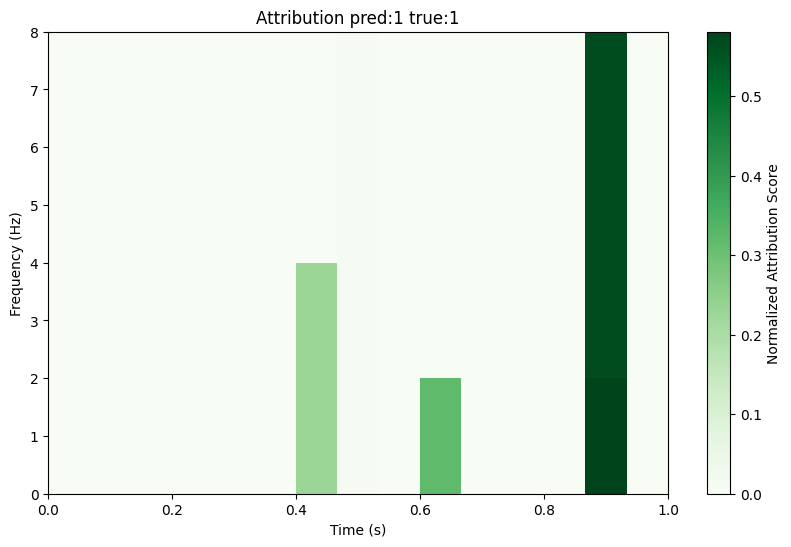

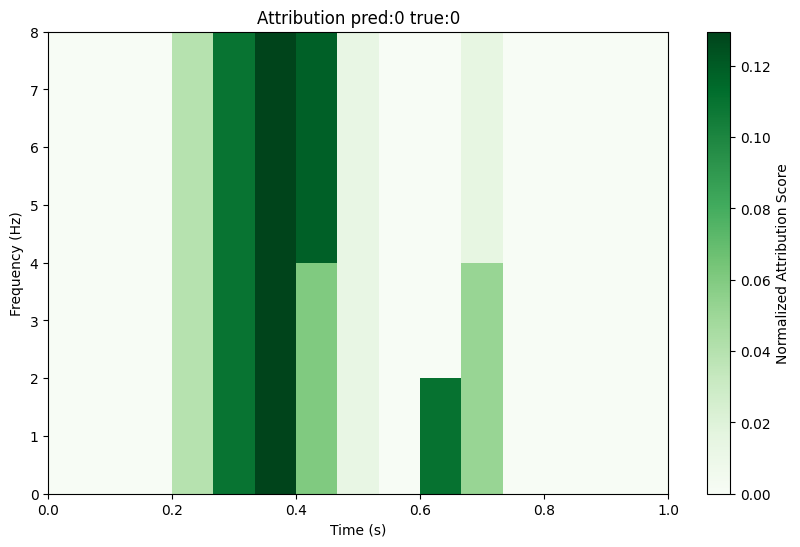

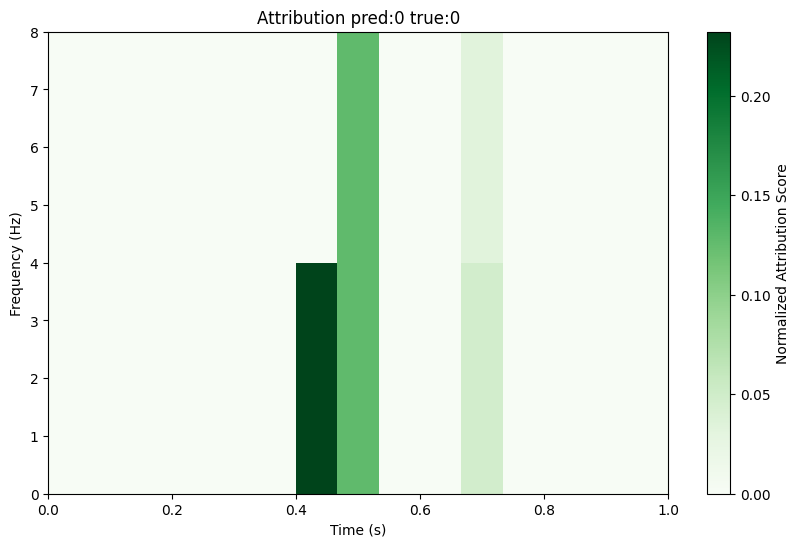

In [35]:
# plot the scores as a heatmap on the original signal
max_level = pywt.dwt_max_level(16, 'db1')

# plot 5 samples
for i in range(1, 10):
    plot_scaleogram_wav_heatmap(x[i][0], attributions['filtermasks_wavelet_db1_4_128'][0][i], prediction=attributions['predictions'][i].argmax(), label=attributions['labels'][i], fs=fs, level=max_level)


128
0.0
0.13582917
0.0
0.5356085
0.0
0.5356085
(16, 5)
(16, 5)


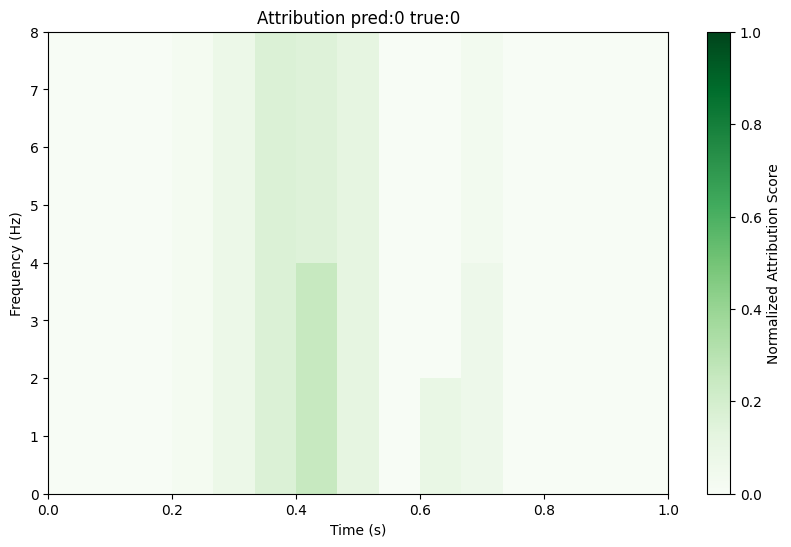

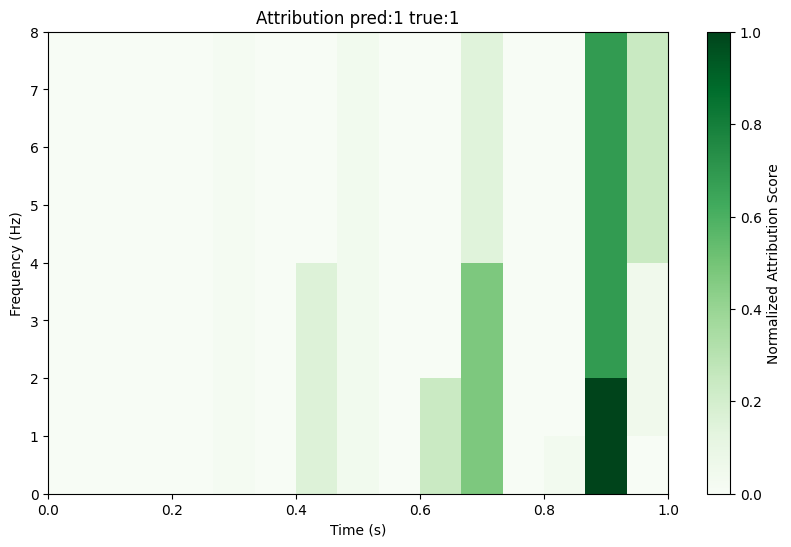

In [45]:
set_seed(42)

# compute an average of the attributions per class
# average the masks for each class
masks_0 = np.zeros_like(attributions[key_2][0][0])
masks_1 = np.zeros_like(attributions[key_2][0][0])

print(len(attributions[key_2][0]))

counts_0 = 0
counts_1 = 0

for i in range(len(attributions[key_2][0])):
    if attributions['labels'][i] == 0:
        masks_0 += attributions[key_2][0][i]
        counts_0 += 1
    else:
        masks_1 += attributions[key_2][0][i]
        counts_1 += 1
masks_0 /= counts_0
masks_1 /= counts_1

masks_0 = np.abs(masks_0)
masks_1 = np.abs(masks_1)

# normalize the masks taking into account the min and max values
masks_0_min = np.min(masks_0)
masks_0_max = np.max(masks_0)
masks_1_min = np.min(masks_1)
masks_1_max = np.max(masks_1)

print(masks_0_min)
print(masks_0_max)
print(masks_1_min)
print(masks_1_max)


if masks_0_min < masks_1_min:
    min = masks_0_min
else:
    min = masks_1_min

if masks_0_max > masks_1_max:
    max = masks_0_max
else:
    max = masks_1_max

print(min)
print(max)

masks_0 = (masks_0 - min) / (max - min + 1e-10)
masks_1 = (masks_1 - min) / (max - min + 1e-10)

print(masks_0.shape)
print(masks_1.shape)

plot_scaleogram_wav_heatmap(x[0][0], masks_0, prediction=0, label=0, fs=fs, level=max_level)
plot_scaleogram_wav_heatmap(x[0][0], masks_1, prediction=1, label=1, fs=fs, level=max_level)


In [30]:
def compute_entropy_sample(attribution, epsilon=1e-10):
    abs_attr = np.abs(attribution)
    sum_attr = np.sum(abs_attr) + epsilon
    prob_dist = abs_attr / sum_attr
    entropy = -np.sum(prob_dist * np.log(prob_dist + epsilon))
    return entropy

In [31]:
# Compute the entropy-based complexity
complexity_scores = []

for i in range(len(attributions[key_])):
    attr = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
    scores = []
    # print(attributions[key_][i].shape)
    for sample in attr:
        sample = sample.detach().cpu().numpy()
        c = compute_entropy_sample(sample)
        c = np.nan_to_num(c)
        scores.append(c)
    complexity_scores += scores

# compute the mean
mean_complexity = np.mean(complexity_scores)
print("Complexity Scores:")
print(mean_complexity)

Complexity Scores:
1.9872845
